# Stats

The code in this notebook can be used to perform a cluster-based permutation test. 

Cluster-based permutation tests helps determine if there are any significant differences across conditions within a time period. However, it does not state that a certain component is a cause of this, or what conditions differ from each other. To further investigate the difference, plotting using the sensors in the significant cluster, as well as the time points can point to what the underlying cause of the difference is. Cluster-based permutation usually works best if you use all brain channels. We need channels that do not have much activity to identify channels that have. Furthermore, one should be aware of the time window of the data used for cluster-based permutation test. Larger effects might hide smaller effects.


Can be done using mne package (https://mne.tools/stable/generated/mne.stats.permutation_cluster_test.html)

**Helpful links:** https://benediktehinger.de/blog/science/statistics-cluster-permutation-test/ and https://www.fieldtriptoolbox.org/tutorial/cluster_permutation_timelock/

In [2]:
#! pip install mne
#! pip install scikit-learn

In [3]:
# importing modules
import numpy as np
import mne
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

#### Reading in epochs
The epochs saved in the `ICA.ipynb` is loaded in for analysis. The data has been cleaned using ICA and downsampled to 250 Hz.

In [4]:
epochs = mne.read_epochs('Stroop_mouse_EEG_data/epochs/epochs_epo.fif')

cropped_epochs = epochs.copy().crop(0.3, 0.5)

### note til andreas, det her er vores epochs :)
#tmin, tmax = -0.2, 0.5
#reject = {'eeg': 150e-6}
#picks = mne.pick_types(raw.info, eeg=True, eog=False)
#epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks, baseline=(None, 0), reject=reject, preload=True, verbose = False)


Reading /Users/laurapaulsen/Documents/Uni/4th semester/Cognitive neuroscience/EGG_and_mouse_tracking/Stroop_mouse_EEG_data/epochs/epochs_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     496.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
350 matching events found
No baseline correction applied
0 projection items activated


/var/folders/4t/gp67d4t56ysgr041byyd6shr0000gn/T/ipykernel_20921/3565814424.py:1: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs('Stroop_mouse_EEG_data/epochs/epochs_epo.fif')
/var/folders/4t/gp67d4t56ysgr041byyd6shr0000gn/T/ipykernel_20921/3565814424.py:1: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs('Stroop_mouse_EEG_data/epochs/epochs_epo.fif')
/var/folders/4t/gp67d4t56ysgr041byyd6shr0000gn/T/ipykernel_20921/3565814424.py:3: RuntimeWarning: tmax is not in epochs time interval. tmax is set to epochs.tmax
  cropped_epochs = epochs.copy().crop(0.3, 0.5)


#### Cluster-based Permutation Test for P3 component
The null hypothesis (H0) is that the data in the two conditions comes from the same probability distribution (i.e. they are interchangeable). In order to test this we scramble the data in the conditions n amount of times to get an idea of what distributions of cluster sizes we would expect if there is no difference between conditions. Based on this distribution we can establish how large a cluster should be to cross our significance level (e.g. 0.05) and then compare this to the clusters based on our conditions. If the highest value from our clusters is larger, this suggests that the data in the conditions are not interchangeable (i.e. the difference between them is significant).

In [5]:
# getting the data from our conditions
X = [epochs[k].get_data(tmin = 0.3, tmax = 0.5) for k in ['Image/cCon', 'Image/cInc', 'Image/cNeu']] # noter dig her, at vi IKKE har det tidsvindue vi laver CLUSBASEDPERM på som epochs men bare en liste med et array per condition

# transposing
X = [np.transpose(x, (0, 2, 1)) for x in X]

##### Channel adjancency

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 28


Text(0.5, 1.0, 'Between-sensor adjacency')

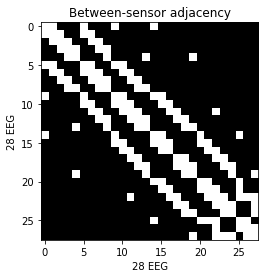

In [6]:
# finding channel adjacency: informs us which channels are next to each other (for co-localisation)
adjacency, ch_names = mne.channels.find_ch_adjacency(epochs.info, ch_type='eeg')

# plotting between-sensor adjacency
plt.imshow(adjacency.toarray(), cmap='gray',
           interpolation='nearest')
plt.xlabel('{} EEG'.format(len(ch_names)))
plt.ylabel('{} EEG'.format(len(ch_names)))
plt.title('Between-sensor adjacency')

##### Permutation test

In [8]:
# set family-wise p-value
p_accept = 0.05

# running the permutation test with 2000 permutations and a random seed of 4
cluster_stats = mne.stats.spatio_temporal_cluster_test(X, n_permutations=1000, tail=0,
                                             n_jobs=-1, buffer_size=None, adjacency=adjacency, seed=4)

# selecting clusters with significant p-values
T_obs, clusters, p_values, _ = cluster_stats
good_cluster_inds = np.where(p_values < p_accept)[0]

Using a threshold of 3.057197
stat_fun(H1): min=0.000147 max=8.943526
Running initial clustering
Found 12 clusters
Permuting 999 times...


/var/folders/4t/gp67d4t56ysgr041byyd6shr0000gn/T/ipykernel_20921/1839925267.py:5: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  cluster_stats = mne.stats.spatio_temporal_cluster_test(X, n_permutations=1000, tail=0,
100%|██████████|  : 999/999 [00:02<00:00,  394.11it/s]


Computing cluster p-values
Done.


In [9]:
print(p_values)
print(good_cluster_inds)

[0.089 0.701 0.77  0.946 0.997 0.921 0.028 0.942 0.798 0.763 0.9   0.914]
[6]


##### Plotting significant

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


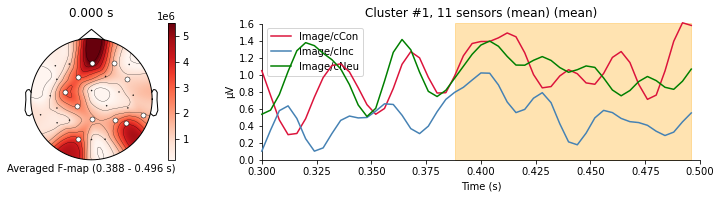

In [10]:
# configuration of variables for visualisation
colors = {'Image/cCon': "crimson", 'Image/cInc': 'steelblue', 'Image/cNeu': 'green'}

evokeds = {cond: cropped_epochs[cond].average() for cond in ['Image/cCon', 'Image/cInc', 'Image/cNeu']} # laver evokeds of tager data fra vores tidsvindue fra permu....


# unpacking cluster information
time_inds, space_inds = np.squeeze(clusters[6]) # cluster[6] = significant cluster
ch_inds = np.unique(space_inds)
time_inds = np.unique(time_inds)

# topography for F stat
f_map = T_obs[time_inds, ...].mean(axis=0)

# finding the time points for significant cluster 
sig_times = cropped_epochs.times[time_inds]

# creating spatial mask
mask = np.zeros((f_map.shape[0], 1), dtype=bool)
mask[ch_inds, :] = True

# initialising the figure
fig, ax_topo = plt.subplots(1, 1, figsize=(10, 3))

# plotting average test statistic and mark significant sensors
f_evoked = mne.EvokedArray(f_map[:, np.newaxis], cropped_epochs.info, tmin=0)
f_evoked.plot_topomap(times=0, mask=mask, axes=ax_topo, cmap='Reds',
                      vmin=np.min, vmax=np.max, show=False,
                      colorbar=False, mask_params=dict(markersize=10))
image = ax_topo.images[0] 

# creating additional axes (for ERF and colorbar)
divider = make_axes_locatable(ax_topo)

# adding axes for colourbar
ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(image, cax=ax_colorbar)
ax_topo.set_xlabel(
    'Averaged F-map ({:0.3f} - {:0.3f} s)'.format(*sig_times[[0, -1]]))

# adding new axis for time courses and plot time courses HER GÅR DET GALT
ax_signals = divider.append_axes('right', size='300%', pad=1.2)
title = 'Cluster #{0}, {1} sensor'.format(1, len(ch_inds))
if len(ch_inds) > 1:
    title += "s (mean)"
mne.viz.plot_compare_evokeds(evokeds, title=title, picks=ch_inds, axes=ax_signals,
                    colors=colors, show=False,
                    split_legend=True, truncate_yaxis='auto', combine = 'mean') 

# plotting temporal cluster extent
ymin, ymax = ax_signals.get_ylim()
ax_signals.fill_betweenx((ymin, ymax), sig_times[0], sig_times[-1],
                        color='orange', alpha=0.3)

# clean-up
mne.viz.tight_layout(fig=fig)
fig.subplots_adjust(bottom=.05)
plt.show()


### Cluster-based permutation test on epochs time-locked to RT


In [11]:
epochs_rt = mne.read_epochs('Stroop_mouse_EEG_data/epochs/epochs_RT_epo.fif')
cropped_epochs_rt = epochs_rt.copy().crop(0.0, 0.6)

Reading /Users/laurapaulsen/Documents/Uni/4th semester/Cognitive neuroscience/EGG_and_mouse_tracking/Stroop_mouse_EEG_data/epochs/epochs_RT_epo.fif ...
    Found the data of interest:
        t =    -700.00 ...     696.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
148 matching events found
No baseline correction applied
0 projection items activated


In [12]:
# getting the data from our conditions
X = [epochs_rt[k].get_data(tmin = 0.0, tmax = 0.6) for k in ['cCon', 'cInc', 'cNeu']] # noter dig her, at vi IKKE har det tidsvindue vi laver CLUSBASEDPERM på som epochs men bare en liste med et array per condition

# transposing
X = [np.transpose(x, (0, 2, 1)) for x in X]

In [13]:
# finding channel adjacency: informs us which channels are next to each other (for co-localisation)
adjacency, ch_names = mne.channels.find_ch_adjacency(epochs_rt.info, ch_type='eeg')

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 28


In [14]:
# set family-wise p-value
p_accept = 0.05

# running the permutation test with 2000 permutations and a random seed of 4
cluster_stats = mne.stats.spatio_temporal_cluster_test(X, n_permutations=1000, tail=0,
                                             n_jobs=-1, buffer_size=None, adjacency=adjacency, seed=4)

# selecting clusters with significant p-values
T_obs, clusters, p_values, _ = cluster_stats
good_cluster_inds = np.where(p_values < p_accept)[0]

Using a threshold of 3.058486
stat_fun(H1): min=0.000175 max=9.571743
Running initial clustering
Found 59 clusters
Permuting 999 times...


/var/folders/4t/gp67d4t56ysgr041byyd6shr0000gn/T/ipykernel_20921/1839925267.py:5: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  cluster_stats = mne.stats.spatio_temporal_cluster_test(X, n_permutations=1000, tail=0,
100%|██████████|  : 999/999 [00:04<00:00,  204.27it/s]


Computing cluster p-values
Done.


In [15]:
print(p_values)
print(good_cluster_inds)

[1.    1.    1.    1.    0.037 1.    1.    1.    1.    0.999 1.    1.
 1.    1.    1.    1.    1.    1.    1.    0.841 1.    1.    1.    1.
 1.    1.    0.953 1.    1.    1.    1.    0.978 1.    1.    1.    1.
 1.    0.921 1.    1.    1.    0.922 0.562 1.    1.    1.    1.    0.999
 1.    1.    1.    1.    1.    1.    1.    1.    1.    0.485 0.915]
[4]


combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


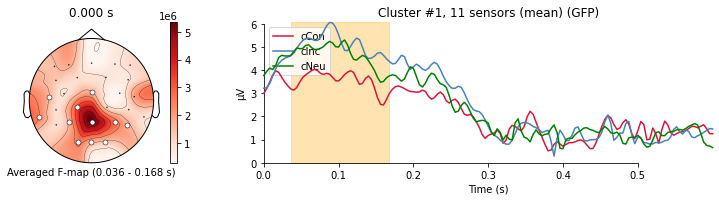

In [16]:
# configuration of variables for visualisation
colors = {'cCon': "crimson", 'cInc': 'steelblue', 'cNeu': 'green'}

evokeds = {cond: cropped_epochs_rt[cond].average() for cond in ['cCon', 'cInc', 'cNeu']}


# unpacking cluster information
time_inds, space_inds = np.squeeze(clusters[4])
ch_inds = np.unique(space_inds)
time_inds = np.unique(time_inds)

# topography for F stat
f_map = T_obs[time_inds, ...].mean(axis=0)

# finding the time points for significant cluster 
sig_times = cropped_epochs_rt.times[time_inds]

# creating spatial mask
mask = np.zeros((f_map.shape[0], 1), dtype=bool)
mask[ch_inds, :] = True

# initialising the figure
fig, ax_topo = plt.subplots(1, 1, figsize=(10, 3))

# plotting average test statistic and mark significant sensors
f_evoked = mne.EvokedArray(f_map[:, np.newaxis], cropped_epochs_rt.info, tmin=0)
f_evoked.plot_topomap(times=0, mask=mask, axes=ax_topo, cmap='Reds',
                      vmin=np.min, vmax=np.max, show=False,
                      colorbar=False, mask_params=dict(markersize=10))
image = ax_topo.images[0] 

# creating additional axes (for ERF and colorbar)
divider = make_axes_locatable(ax_topo)

# adding axes for colourbar
ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(image, cax=ax_colorbar)
ax_topo.set_xlabel(
    'Averaged F-map ({:0.3f} - {:0.3f} s)'.format(*sig_times[[0, -1]]))

# adding new axis for time courses and plot time courses HER GÅR DET GALT
ax_signals = divider.append_axes('right', size='300%', pad=1.2)
title = 'Cluster #{0}, {1} sensor'.format(1, len(ch_inds))
if len(ch_inds) > 1:
    title += "s (mean)"
mne.viz.plot_compare_evokeds(evokeds, title=title, picks=ch_inds, axes=ax_signals,
                    colors=colors, show=False,
                    split_legend=True, truncate_yaxis='auto', combine = 'gfp') 

# plotting temporal cluster extent
ymin, ymax = ax_signals.get_ylim()
ax_signals.fill_betweenx((ymin, ymax), sig_times[0], sig_times[-1],
                        color='orange', alpha=0.3)

# clean-up
mne.viz.tight_layout(fig=fig)
fig.subplots_adjust(bottom=.05)
plt.show()